## Migration network completion
There are evidences that migration and trade networks are linked [1]. As we are missing many of the migration links, in this notebook we explore the possibility of completing the migration network using trande network info

[1] Sgrignoli, P., Metulini, R., Schiavo, S., Riccaboni, M., 2015. The relation between global migration and trade networks. Physica A: Statistical Mechanics and its Applications 417, 245–260. https://doi.org/10.1016/j.physa.2014.09.037



In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from urllib.parse import urlparse
from functools import reduce

from src.utils.utils_s3 import read_s3_graphml
from src.data.migration_network import EstimatedMigrationNetwork

In [4]:
year='2000'

In [5]:
B = read_s3_graphml(os.path.join(output_filepath, year, 'B_country.graphml'))
A = read_s3_graphml(os.path.join(output_filepath, year, 'A_country.graphml'))
M = read_s3_graphml(os.path.join(output_filepath, year, 'migration_network.graphml'))

In [6]:
df_list = []

for network in A, B, M:
    link_list = [(c1, c2, w['weight']) for c1, c2, w in network.edges(data=True)]
    df_ = pd.DataFrame(link_list, columns = ['country_from', 'country_to', 'weight'])
    df_.set_index(['country_from', 'country_to'], inplace=True)
    
    df_list.append(df_)

In [7]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on=['country_from', 'country_to'], how='outer'), df_list)
df.columns = ['a_link', 'b_link', 'm_link']

In [8]:
df.describe()

,a_link,b_link,m_link
count,3.608600e+04,3.608600e+04,3.386000e+03
mean,2.780746e-03,2.605745e-03,2.352352e-04
std,3.003738e-02,2.847796e-02,1.551834e-03
min,1.598514e-08,5.255250e-08,0.000000e+00
25%,5.680171e-06,6.061405e-06,7.227625e-07
50%,2.385844e-05,2.391681e-05,8.229525e-06
75%,1.315281e-04,1.109316e-04,5.400679e-05
max,6.792153e-01,6.711338e-01,5.184464e-02


## Simple regression model

In [9]:
df_model = df[df.b_link>1.e-6]
df_model = df_model.dropna()

In [10]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
    
y = df_model['m_link']
X = df_model[['a_link', 'b_link']]
X = sm.add_constant(X)

model = sm.OLS(y,X)
model = QuantReg(y,X)

results = model.fit(q=.99)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 m_link   Pseudo R-squared:               0.4526
Model:                       QuantReg   Bandwidth:                   0.0004299
Method:                 Least Squares   Sparsity:                      0.07695
Date:                Wed, 18 Aug 2021   No. Observations:                 3372
Time:                        09:18:15   Df Residuals:                     3369
                                        Df Model:                            2
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      4.573      0.000       0.000       0.001
a_link         0.5803      0.021     27.292      0.000       0.539       0.622
b_link         0.2249      0.019     11.590      0.000       0.187       0.263
==============================================================================
"""

## Dummy model
DIOC-E (release 3.0) (year 2000) data found in https://www.un.org/en/development/desa/population/migration/data/estimates2/estimates19.asp

In [11]:
B = read_s3_graphml(os.path.join(output_filepath, '2015', 'B_country.graphml'))

e = EstimatedMigrationNetwork(B, input_filepath, output_filepath)
estimated_M = e.estimate_emigration_rate()

In [12]:
df_list = []

for network in A, B, M, estimated_M:
    link_list = [(c1, c2, w['weight']) for c1, c2, w in network.edges(data=True)]
    df_ = pd.DataFrame(link_list, columns = ['country_from', 'country_to', 'weight'])
    df_.set_index(['country_from', 'country_to'], inplace=True)
    
    df_list.append(df_)
    
df = reduce(lambda df1,df2: pd.merge(df1,df2,on=['country_from', 'country_to'], how='outer'), df_list)
df.columns = ['a_link', 'b_link', 'm_link', 'm_estimated_link']

In [13]:
df.dropna().sort_values(by='m_link')

a_link    b_link    m_link  m_estimated_link
country_from country_to                                                
PRY          DEU         0.002475  0.000600  0.000000          0.000105
BLZ          LUX         0.000048  0.000078  0.000000          0.000045
             ISL         0.000062  0.000064  0.000000          0.000037
             FIN         0.000102  0.000143  0.000000          0.000082
             DNK         0.000532  0.000254  0.000000          0.000146
...                           ...       ...       ...               ...
ECU          ESP         0.001983  0.001000  0.016368          0.000153
NZL          AUS         0.018703  0.020624  0.016390          0.004560
GUY          USA         0.034574  0.000241  0.020781          0.000183
ALB          ITA         0.035133  0.015275  0.024118          0.008296
WSM          NZL         0.009734  0.001985  0.051845          0.001623

[3319 rows x 4 columns]

In [14]:
df.dropna().describe(include='all')

,a_link,b_link,m_link,m_estimated_link
count,3.319000e+03,3.319000e+03,3.319000e+03,3319.000000
mean,3.029292e-03,2.694715e-03,2.129460e-04,0.000342
std,1.379224e-02,1.229891e-02,1.387424e-03,0.001603
min,5.458827e-07,1.949971e-07,0.000000e+00,0.000000
25%,1.367265e-04,6.383306e-05,8.031862e-07,0.000005
50%,5.093220e-04,2.961926e-04,8.492266e-06,0.000029
75%,1.956327e-03,1.623849e-03,5.483466e-05,0.000176
max,4.043944e-01,3.516657e-01,5.184464e-02,0.064429


In [15]:
df[(df.b_link == 0)].sort_values(by='m_estimated_link').dropna()

,,a_link,b_link,m_link,m_estimated_link
country_from,country_to,,,,


In [16]:
df[df.index.get_level_values(0) == 'ATG']

a_link    b_link  m_link  m_estimated_link
country_from country_to                                              
ATG          ATG         0.432588  0.391707     NaN          0.000000
             ABW         0.000052  0.000319     NaN          0.000196
             AFG         0.000046  0.000092     NaN          0.000056
             AGO         0.000045  0.000125     NaN          0.000077
             ALB         0.000047  0.000082     NaN          0.000050
...                           ...       ...     ...               ...
             WSM         0.000046  0.000061     NaN          0.000038
             YEM         0.000045  0.000132     NaN          0.000081
             ZAF         0.000178  0.000435     NaN          0.000267
             ZMB         0.000046  0.000095     NaN          0.000058
             ZWE         0.000045  0.000028     NaN          0.000017

[190 rows x 4 columns]

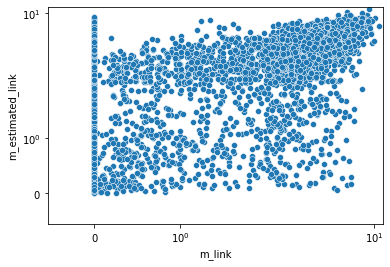

In [17]:
ax = sns.scatterplot(data=df.applymap(lambda x: np.log1p(x*1000000)), x = 'm_link', y = 'm_estimated_link')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

<AxesSubplot:xlabel='0', ylabel='level_2'>

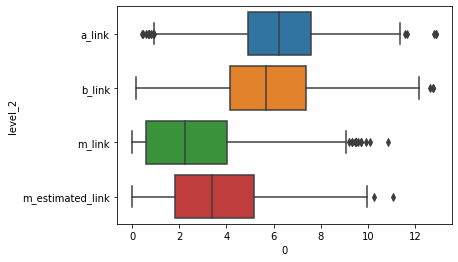

In [18]:
sns.boxplot(data = df.applymap(lambda x: np.log1p(x*1000000)).dropna().stack().reset_index(), x = 0, y = 'level_2')

In [19]:
df_model = df.applymap(lambda x: np.log1p(x*1000000)).dropna()

y = df_model['m_link']
X = df_model[['m_estimated_link']]
X = sm.add_constant(X)

model = sm.OLS(y,X)
#model = QuantReg(y,X)

results = model.fit(q=.99)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 m_link   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     1351.
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          2.03e-248
Time:                        09:18:18   Log-Likelihood:                -6707.3
No. Observations:                3319   AIC:                         1.342e+04
Df Residuals:                    3317   BIC:                         1.343e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6590      0.061     10.868      0.000       0.540       0.778
m_estimated_link     0.5349      0.015     36.756      0.000       0.506       0.563
==============================================================================
Omnibus:                       48.527   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.405
Skew:                           0.210   Prob(JB):                     4.63e-14
Kurtosis:                       3.518   Cond. No.                         8.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
A = nx.adjacency_matrix(estimated_M, nodelist=estimated_M.nodes, weight='weight')
A = A.todense()
A

matrix([[0.00000000e+00, 1.07618684e-05, 1.46567544e-05, ...,
         2.87163533e-05, 1.16288028e-05, 3.12110328e-06],
        [2.39459723e-07, 0.00000000e+00, 3.25503108e-07, ...,
         6.68345540e-07, 2.67232621e-07, 8.47919720e-08],
        [1.48437876e-07, 1.50445505e-07, 0.00000000e+00, ...,
         3.47979969e-06, 1.72668018e-07, 6.90929162e-08],
        ...,
        [4.73888477e-08, 6.15937605e-08, 4.02521859e-05, ...,
         0.00000000e+00, 4.63307260e-05, 2.28554712e-05],
        [5.03649581e-07, 4.85974459e-07, 2.87202912e-05, ...,
         2.55424876e-04, 0.00000000e+00, 9.17257989e-06],
        [8.55833139e-06, 8.69505689e-06, 4.75759165e-06, ...,
         1.20043146e-05, 7.23648021e-06, 0.00000000e+00]])

In [21]:
A.sum(axis=0)

matrix([[0.0011262 , 0.00172106, 0.00489394, 0.00204868, 0.0005715 ,
         0.00119193, 0.00748131, 0.01078274, 0.00176489, 0.0009555 ,
         0.03755955, 0.02235639, 0.00263777, 0.00121608, 0.04832429,
         0.00151409, 0.00217756, 0.0013444 , 0.0042441 , 0.00098922,
         0.00089949, 0.00291545, 0.02701736, 0.00079651, 0.0010333 ,
         0.00152209, 0.0382496 , 0.00107312, 0.00087436, 0.00196556,
         0.00099372, 0.00058414, 0.02505704, 0.02081613, 0.00808335,
         0.11387127, 0.00099681, 0.00108067, 0.00196072, 0.00140045,
         0.00508754, 0.00084049, 0.00520466, 0.00205983, 0.0010155 ,
         0.00124686, 0.01729618, 0.21238724, 0.000617  , 0.01725854,
         0.00197529, 0.00328264, 0.0034335 , 0.00314347, 0.00054661,
         0.04573472, 0.0054279 , 0.00105575, 0.01576329, 0.00086022,
         0.08632758, 0.00107366, 0.10027772, 0.00429377, 0.00164419,
         0.00121447, 0.00045929, 0.01360655, 0.00875022, 0.08782389,
         0.01027719, 0.00633806, 0

In [22]:
remove = [node for node,degree in dict(estimated_M.out_degree(weight='weight')).items() if degree == 0] 
remove

[]

In [23]:
df.groupby('country_from').m_estimated_link.apply(lambda x: x.isnull().mean()).sort_values().tail(50)

country_from
GTM    0.052632
GUY    0.052632
HKG    0.052632
HND    0.052632
HRV    0.052632
HTI    0.052632
HUN    0.052632
IDN    0.052632
IND    0.052632
IRL    0.052632
IRN    0.052632
IRQ    0.052632
ISL    0.052632
ISR    0.052632
ITA    0.052632
JAM    0.052632
JOR    0.052632
JPN    0.052632
KAZ    0.052632
CYP    0.052632
GHA    0.052632
ZWE    0.052632
GBR    0.052632
CZE    0.052632
DEU    0.052632
DJI    0.052632
DNK    0.052632
DOM    0.052632
DZA    0.052632
ECU    0.052632
EGY    0.052632
GEO    0.052632
ESP    0.052632
ERI    0.052632
ETH    0.052632
FIN    0.052632
FJI    0.052632
FRA    0.052632
GAB    0.052632
EST    0.052632
SDS    1.000000
NCL    1.000000
SRB    1.000000
USR    1.000000
ROW    1.000000
GRL    1.000000
SUD    1.000000
PYF    1.000000
MNE    1.000000
PRK    1.000000
Name: m_estimated_link, dtype: float64

In [24]:
df.groupby('country_to').m_estimated_link.apply(lambda x: x.isnull().mean()).sort_values().tail()

country_to
GRL    1.0
SUD    1.0
PYF    1.0
MNE    1.0
PRK    1.0
Name: m_estimated_link, dtype: float64

In [26]:
h,a=nx.hits(estimated_M, max_iter=750)

In [27]:
nx.pagerank(estimated_M, max_iter=1000, weight='weight')

{'ABW': 0.0009663052516035855,
 'AFG': 0.0010406048993231286,
 'AGO': 0.0017443274708666345,
 'ALB': 0.0011574228356577637,
 'AND': 0.0009112121462118563,
 'ANT': 0.0009421344068466044,
 'ARE': 0.0052247665249729,
 'ARG': 0.004855795869426412,
 'ARM': 0.0010057203969392197,
 'ATG': 0.0009115910050827155,
 'AUS': 0.011171309434089118,
 'AUT': 0.010116709178843402,
 'AZE': 0.0012303101081390896,
 'BDI': 0.0009508322337256032,
 'BEL': 0.025848456219988637,
 'BEN': 0.0010263588142591974,
 'BFA': 0.0011132581716238558,
 'BGD': 0.0015208628619864358,
 'BGR': 0.0018556684843846739,
 'BHR': 0.0010913367379738203,
 'BHS': 0.0010147063994846823,
 'BIH': 0.0011166990797503303,
 'BLR': 0.0027944275240100983,
 'BLZ': 0.0009204532597092144,
 'BMU': 0.0009625163892549414,
 'BOL': 0.0011694492087240985,
 'BRA': 0.012761378857870665,
 'BRB': 0.0009949804157944613,
 'BRN': 0.0010076965834692978,
 'BTN': 0.001013774078840715,
 'BWA': 0.0010990070426179874,
 'CAF': 0.0008999650409283012,
 'CAN': 0.0278654